In [96]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from scipy.sparse.linalg import svds
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.image as mpimgimport
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from statistics import mean
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import shuffle
from zipfile import ZipFile
from tqdm import tqdm
##Deep Learning specific stuff
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate,Add
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Flatten,Activation,Input,Embedding
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.layers import dot
from tensorflow.keras.models import Model

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
%%time

book_rating = pd.DataFrame()
for file in glob.glob("/content/drive/MyDrive/Datasets/Goodreads/book*.csv"):
    df = pd.read_csv(file)
    if book_rating.empty:
        book_rating = df
    else:
        book_rating = pd.concat([book_rating, df], ignore_index=True)


user_rating = pd.DataFrame()
for file in glob.glob("/content/drive/MyDrive/Datasets/Goodreads/user_rating*.csv"):
    df = pd.read_csv(file)
    if user_rating.empty:
        user_rating = df
    else:
        user_rating = pd.concat([user_rating, df], ignore_index=True)

CPU times: user 19.7 s, sys: 1.89 s, total: 21.6 s
Wall time: 22.3 s


In [57]:
book_rating.shape,user_rating.shape

((1850310, 21), (362596, 3))

In [58]:
user_rating.head()

,ID,Name,Rating
0,1,Agile Web Development with Rails: A Pragmatic ...,it was amazing
1,1,The Restaurant at the End of the Universe (Hit...,it was amazing
2,1,Siddhartha,it was amazing
3,1,The Clock of the Long Now: Time and Responsibi...,really liked it
4,1,"Ready Player One (Ready Player One, #1)",really liked it


In [59]:
book_rating.head(3)

,Id,Name,RatingDist1,pagesNumber,RatingDist4,RatingDistTotal,PublishMonth,PublishDay,Publisher,CountsOfReview,...,Language,Authors,Rating,RatingDist2,RatingDist5,ISBN,RatingDist3,Description,Count of text reviews,PagesNumber
0,1,Harry Potter and the Half-Blood Prince (Harry ...,1:9896,652.0,4:556485,total:2298124,16,9,Scholastic Inc.,28062,...,eng,J.K. Rowling,4.57,2:25317,5:1546466,NaN,3:159960,NaN,NaN,NaN
1,2,Harry Potter and the Order of the Phoenix (Har...,1:12455,870.0,4:604283,total:2358637,1,9,Scholastic Inc.,29770,...,eng,J.K. Rowling,4.50,2:37005,5:1493113,0439358078,3:211781,NaN,NaN,NaN
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,1:108202,309.0,4:1513191,total:6587388,1,11,Scholastic Inc,75911,...,eng,J.K. Rowling,4.47,2:130310,5:4268227,NaN,3:567458,NaN,NaN,NaN


In [60]:
book_rating.columns

Index(['Id', 'Name', 'RatingDist1', 'pagesNumber', 'RatingDist4',
       'RatingDistTotal', 'PublishMonth', 'PublishDay', 'Publisher',
       'CountsOfReview', 'PublishYear', 'Language', 'Authors', 'Rating',
       'RatingDist2', 'RatingDist5', 'ISBN', 'RatingDist3', 'Description',
       'Count of text reviews', 'PagesNumber'],
      dtype='object')

There is a lot of additional meta data for books available here. Let's try and prepare few columns that we can use.

In [61]:
book_rating['Num_1star_rating']=book_rating['RatingDist1'].str.split('\:').str[-1].str.strip()
book_rating['Num_2star_rating']=book_rating['RatingDist2'].str.split('\:').str[-1].str.strip()
book_rating['Num_3star_rating']=book_rating['RatingDist3'].str.split('\:').str[-1].str.strip()
book_rating['Num_4star_rating']=book_rating['RatingDist4'].str.split('\:').str[-1].str.strip()
book_rating['Num_5star_rating']=book_rating['RatingDist5'].str.split('\:').str[-1].str.strip()
book_rating['Num_1star_rating'] = book_rating['Num_1star_rating'].astype(int)
book_rating['Num_2star_rating'] = book_rating['Num_2star_rating'].astype(int)
book_rating['Num_3star_rating'] = book_rating['Num_3star_rating'].astype(int)
book_rating['Num_4star_rating'] = book_rating['Num_4star_rating'].astype(int)
book_rating['Num_5star_rating'] = book_rating['Num_5star_rating'].astype(int)
book_rating['Total_rating_count']= book_rating['Num_1star_rating']+book_rating['Num_2star_rating']+book_rating['Num_3star_rating']+book_rating['Num_4star_rating']+book_rating['Num_5star_rating']
book_rating['Pct_1Star']=book_rating['Num_1star_rating']/book_rating['Total_rating_count']
book_rating['Pct_2Star']=book_rating['Num_2star_rating']/book_rating['Total_rating_count']
book_rating['Pct_3Star']=book_rating['Num_3star_rating']/book_rating['Total_rating_count']
book_rating['Pct_4Star']=book_rating['Num_4star_rating']/book_rating['Total_rating_count']
book_rating['Pct_5Star']=book_rating['Num_5star_rating']/book_rating['Total_rating_count']
book_rating.tail()

,Id,Name,RatingDist1,pagesNumber,RatingDist4,RatingDistTotal,PublishMonth,PublishDay,Publisher,CountsOfReview,...,Num_2star_rating,Num_3star_rating,Num_4star_rating,Num_5star_rating,Total_rating_count,Pct_1Star,Pct_2Star,Pct_3Star,Pct_4Star,Pct_5Star
1850305,999991,Gendered Talk at Work: Constructing Gender Ide...,1:0,251.0,4:3,total:25,21,7,Wiley-Blackwell,0,...,1,6,3,15,25,0.000000,0.040000,0.240000,0.120000,0.600000
1850306,999992,Good Will Toward Men: Women Talk Candidly abou...,1:0,231.0,4:0,total:0,1,2,St. Martin's Press,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1850307,999993,Would You Rather . . . ?: The Outrageous Book ...,1:2,400.0,4:35,total:121,1,10,Workman Publishing Company,14,...,11,34,35,39,121,0.016529,0.090909,0.280992,0.289256,0.322314
1850308,999997,Addictions Treatment for Older Adults: Evaluat...,1:0,258.0,4:0,total:0,2,2,Routledge,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1850309,999998,Within/Without,1:0,36.0,4:0,total:2,1,3,"Pilgrims Process, Inc.",0,...,0,0,0,2,2,0.000000,0.000000,0.000000,0.000000,1.000000


In [99]:
book_rating_df = book_rating[['Name','pagesNumber','PublishMonth','PublishDay',
                              'CountsOfReview','Num_1star_rating','Num_2star_rating',
                              'Num_3star_rating','Num_4star_rating','Num_5star_rating']]
scalable_cols = ['pagesNumber','PublishMonth','PublishDay',
                              'CountsOfReview','Num_1star_rating','Num_2star_rating',
                              'Num_3star_rating','Num_4star_rating','Num_5star_rating']
def mix_max_scaler(df, scalable_cols):
    result = df.copy()
    for feature_name in scalable_cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
book_rating_scaled = mix_max_scaler(book_rating, scalable_cols)
book_rating_df = book_rating_scaled[['Name','pagesNumber','PublishMonth','PublishDay',\
                              'CountsOfReview','Num_1star_rating','Num_2star_rating',\
                              'Num_3star_rating','Num_4star_rating','Num_5star_rating']]

In [101]:
##Let's create Book_id that we can use
book_id_0 = book_rating_df[['Name']]
book_id_1 = user_rating [['Name']]
book_id = pd.concat([book_id_0,book_id_1],axis=0,ignore_index=True)
book_id.rename(columns={ book_id.columns[0]: "Name" }, inplace = True)
book_id.drop_duplicates(inplace=True)
book_id['Book_Id']=book_id.index.values
book_id.head()

,Name,Book_Id
0,Harry Potter and the Half-Blood Prince (Harry ...,0
1,Harry Potter and the Order of the Phoenix (Har...,1
2,Harry Potter and the Sorcerer's Stone (Harry P...,2
3,Harry Potter and the Chamber of Secrets (Harry...,3
4,Harry Potter and the Prisoner of Azkaban (Harr...,4


In [134]:
book2bookid = {}
bookid2book = {}
for i in tqdm(range(len(book_id))):
  book2bookid[book_id.iloc[i,:]["Name"].lower()] = book_id.iloc[i,:]["Book_Id"]
  bookid2book[book_id.iloc[i,:]["Book_Id"]] = book_id.iloc[i,:]["Name"]
len(book2bookid)

100%|██████████| 1688309/1688309 [10:31<00:00, 2673.59it/s]


1662104

In [135]:
import pickle
with open("/content/drive/MyDrive/Datasets/Goodreads/hashmap_book2id.pkl", "wb") as f:
  pickle.dump(book2bookid, f)
pickle.dump(bookid2book, open("/content/drive/MyDrive/Datasets/Goodreads/hashmap_id2book.pkl", "wb"))

In [66]:
user_rating.head(3)

,ID,Name,Rating
0,1,Agile Web Development with Rails: A Pragmatic ...,it was amazing
1,1,The Restaurant at the End of the Universe (Hit...,it was amazing
2,1,Siddhartha,it was amazing


### Filter users to keep only those that reviewed at least K books
* Minimum values vary, but 5~20 seems reasonable for the context of non cold starts cases with MF.
* Note that we lack user information


In [104]:
print(user_rating.shape[0],"rows")
print(user_rating["ID"].nunique())

1145892 rows
2436


In [105]:
user_rating.groupby(["ID"])["Rating"].size().describe().round()

count    2436.0
mean      470.0
std       641.0
min        15.0
25%       122.0
50%       247.0
75%       565.0
max      8041.0
Name: Rating, dtype: float64

In [69]:
## filter for users with at least K reviews.
user_rating = user_rating[user_rating['ID'].groupby(user_rating['ID']).transform('size')>=15]

print(user_rating.shape[0],"rows")
print(user_rating["ID"].nunique())

349529 rows
2436


In [70]:
book_id

,Name,Book_Id
0,Harry Potter and the Half-Blood Prince (Harry ...,0
1,Harry Potter and the Order of the Phoenix (Har...,1
2,Harry Potter and the Sorcerer's Stone (Harry P...,2
3,Harry Potter and the Chamber of Secrets (Harry...,3
4,Harry Potter and the Prisoner of Azkaban (Harr...,4
...,...,...
2212870,أكابر,2212870
2212871,Travels of IBN Battuta A.D. 1325-1354- 3 Vol.'s,2212871
2212881,"A BOOK OF MEDITATIONS, VOLUME TWO: 1995-2001 R...",2212881
2212884,The Arab Israeli Conflict: A History,2212884


In [71]:
book_rating_df

,Name,pagesNumber,PublishMonth,PublishDay,CountsOfReview,Num_1star_rating,Num_2star_rating,Num_3star_rating,Num_4star_rating,Num_5star_rating
0,Harry Potter and the Half-Blood Prince (Harry ...,0.000144,0.500000,0.266667,0.181693,0.017980,0.046531,0.157881,0.291024,3.355327e-01
1,Harry Potter and the Order of the Phoenix (Har...,0.000193,0.000000,0.266667,0.192752,0.022629,0.068012,0.209029,0.316021,3.239568e-01
2,Harry Potter and the Sorcerer's Stone (Harry P...,0.000068,0.000000,0.333333,0.491502,0.196592,0.239499,0.560084,0.791352,9.260652e-01
3,Harry Potter and the Chamber of Secrets (Harry...,0.000078,0.000000,0.333333,0.001580,0.021614,0.090707,0.285068,0.369259,3.264285e-01
4,Harry Potter and the Prisoner of Azkaban (Harr...,0.000096,0.000000,0.133333,0.240167,0.018402,0.045671,0.192316,0.329750,3.796837e-01
...,...,...,...,...,...,...,...,...,...,...
1850305,Gendered Talk at Work: Constructing Gender Ide...,0.000056,0.666667,0.200000,0.000000,0.000000,0.000002,0.000006,0.000002,3.688440e-06
1850306,Good Will Toward Men: Women Talk Candidly abou...,0.000051,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,4.339342e-07
1850307,Would You Rather . . . ?: The Outrageous Book ...,0.000089,0.000000,0.300000,0.000091,0.000004,0.000020,0.000034,0.000018,8.895651e-06
1850308,Addictions Treatment for Older Adults: Evaluat...,0.000057,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,4.339342e-07


In [106]:
user_rating

,ID,Name,Rating,Book_Id,Rating_numeric,pagesNumber,PublishMonth,PublishDay,CountsOfReview,Num_1star_rating,Num_2star_rating,Num_3star_rating,Num_4star_rating,Num_5star_rating
0,0,Agile Web Development with Rails: A Pragmatic ...,it was amazing,0,5,0.000124,0.900000,0.200000,0.000382,0.000102,0.000228,0.000494,0.000429,1.262748e-04
1,0,The Restaurant at the End of the Universe (Hit...,it was amazing,1,5,0.000055,0.833333,0.100000,0.024177,0.001624,0.008739,0.033341,0.044078,2.060319e-02
2,0,The Restaurant at the End of the Universe (Hit...,it was amazing,1,5,0.000055,0.366667,0.300000,0.000097,0.001930,0.009195,0.034020,0.044859,2.094687e-02
3,0,Siddhartha,it was amazing,2,5,0.000021,0.000000,0.166667,0.000473,0.023149,0.057764,0.103003,0.094283,4.736131e-02
4,0,Siddhartha,it was amazing,2,5,0.000032,0.533333,0.300000,0.000013,0.023198,0.057904,0.103305,0.094628,4.757850e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145887,2356,The Question of Palestine,really liked it,79475,4,0.000071,0.200000,0.100000,0.000330,0.000049,0.000050,0.000162,0.000257,1.269257e-04
1145888,2356,The Question of Palestine,really liked it,79475,4,0.000059,0.200000,0.100000,0.000000,0.000049,0.000050,0.000167,0.000260,1.275766e-04
1145889,2356,Out of Place,it was amazing,2374,5,0.000084,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000002,6.509013e-07
1145890,2356,Out of Place,it was amazing,2374,5,0.000000,0.266667,0.000000,0.000000,0.000002,0.000004,0.000003,0.000005,1.735737e-06


In [72]:
user_rating = pd.merge(user_rating,book_id, on='Name', how='left')
book_rating_df = pd.merge(book_rating_df,book_id, on='Name', how='left')
user_rating.head()

,ID,Name,Rating,Book_Id
0,1,Agile Web Development with Rails: A Pragmatic ...,it was amazing,28
1,1,The Restaurant at the End of the Universe (Hit...,it was amazing,5295
2,1,Siddhartha,it was amazing,2678
3,1,The Clock of the Long Now: Time and Responsibi...,really liked it,1850313
4,1,"Ready Player One (Ready Player One, #1)",really liked it,1850314


In [73]:
user_rating['Rating'].unique()

array(['it was amazing', 'really liked it', 'liked it', 'did not like it',
       'it was ok'], dtype=object)

In [74]:
# le = preprocessing.LabelEncoder()
user_rating['Rating_numeric'] = user_rating.Rating.map({'did not like it': 1,
                                                        'it was amazing': 5,
                                                        'it was ok': 2,
                                                        'liked it': 3,
                                                        'really liked it': 4})
book_rating_numeric = book_rating_df[['Book_Id','pagesNumber','PublishMonth','PublishDay',\
                              'CountsOfReview','Num_1star_rating','Num_2star_rating',\
                              'Num_3star_rating','Num_4star_rating','Num_5star_rating']]
user_rating = pd.merge(user_rating,book_rating_numeric, on='Book_Id', how='left')
user_rating.head()

,ID,Name,Rating,Book_Id,Rating_numeric,pagesNumber,PublishMonth,PublishDay,CountsOfReview,Num_1star_rating,Num_2star_rating,Num_3star_rating,Num_4star_rating,Num_5star_rating
0,1,Agile Web Development with Rails: A Pragmatic ...,it was amazing,28,5,0.000124,0.900000,0.200000,0.000382,0.000102,0.000228,0.000494,0.000429,0.000126
1,1,The Restaurant at the End of the Universe (Hit...,it was amazing,5295,5,0.000055,0.833333,0.100000,0.024177,0.001624,0.008739,0.033341,0.044078,0.020603
2,1,The Restaurant at the End of the Universe (Hit...,it was amazing,5295,5,0.000055,0.366667,0.300000,0.000097,0.001930,0.009195,0.034020,0.044859,0.020947
3,1,Siddhartha,it was amazing,2678,5,0.000021,0.000000,0.166667,0.000473,0.023149,0.057764,0.103003,0.094283,0.047361
4,1,Siddhartha,it was amazing,2678,5,0.000032,0.533333,0.300000,0.000013,0.023198,0.057904,0.103305,0.094628,0.047578


In [75]:
user_rating.Rating_numeric.unique()

array([5, 4, 3, 1, 2])

In [76]:
user_rating.fillna(0, inplace=True)

In [77]:
users = user_rating.ID.unique()
books = user_rating.Book_Id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
bookid2idx = {o:i for i,o in enumerate(books)}
user_rating['ID'] = user_rating['ID'].apply(lambda x: userid2idx[x])
user_rating['Book_Id'] = user_rating['Book_Id'].apply(lambda x: bookid2idx[x])
y=user_rating['Rating_numeric']
X=user_rating.drop(['Rating_numeric'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape , X_test.shape)

(916713, 13) (229179, 13)


In [78]:
exogenous_train = np.array(X_train[['pagesNumber','PublishMonth','PublishDay',\
                              'CountsOfReview','Num_1star_rating','Num_2star_rating',\
                              'Num_3star_rating','Num_4star_rating','Num_5star_rating']])
exogenous_valid = np.array(X_test[['pagesNumber','PublishMonth','PublishDay',\
                              'CountsOfReview','Num_1star_rating','Num_2star_rating',\
                              'Num_3star_rating','Num_4star_rating','Num_5star_rating']])

In [79]:
X.head()

,ID,Name,Rating,Book_Id,pagesNumber,PublishMonth,PublishDay,CountsOfReview,Num_1star_rating,Num_2star_rating,Num_3star_rating,Num_4star_rating,Num_5star_rating
0,0,Agile Web Development with Rails: A Pragmatic ...,it was amazing,0,0.000124,0.900000,0.200000,0.000382,0.000102,0.000228,0.000494,0.000429,0.000126
1,0,The Restaurant at the End of the Universe (Hit...,it was amazing,1,0.000055,0.833333,0.100000,0.024177,0.001624,0.008739,0.033341,0.044078,0.020603
2,0,The Restaurant at the End of the Universe (Hit...,it was amazing,1,0.000055,0.366667,0.300000,0.000097,0.001930,0.009195,0.034020,0.044859,0.020947
3,0,Siddhartha,it was amazing,2,0.000021,0.000000,0.166667,0.000473,0.023149,0.057764,0.103003,0.094283,0.047361
4,0,Siddhartha,it was amazing,2,0.000032,0.533333,0.300000,0.000013,0.023198,0.057904,0.103305,0.094628,0.047578


In [80]:
from tensorflow.keras.regularizers import l1, l2

def build_model(dropout,latent_factors):
    n_books=len(user_rating['Book_Id'].unique())
    n_users=len(user_rating['ID'].unique())
    n_latent_factors=latent_factors  # hyperparamter to deal with.
    user_input=Input(shape=(1,),name='user_input',dtype='int64')
    user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
    user_vec =Flatten(name='FlattenUsers')(user_embedding)
    user_vec=Dropout(dropout)(user_vec)
    book_input=Input(shape=(1,),name='book_input',dtype='int64')
    book_embedding=Embedding(n_books,n_latent_factors,name='book_embedding')(book_input)
    book_vec=Flatten(name='FlattenBooks')(book_embedding)
    book_vec=Dropout(dropout)(book_vec)
    sim=dot([user_vec,book_vec],name='Similarity-Dot-Product',axes=1)
    ###Exogenous Features input
    exog_input = Input(shape=(9,),name='exogenous_input',dtype='float64')
    exog_embedding = Embedding(9,20,name='exog_embedding')(exog_input)
    exog_embedding = Dense(65,activation='relu',name='exog_Dense')(exog_input)
    exog_vec =Flatten(name='FlattenExog')(exog_embedding)
    ##############
#     nn_inp = Add(dtype='float64',name='Combine_inputs')([sim,exog_vec]) # ORIG, added, ndidn't concat
    nn_inp = tf.keras.layers.Concatenate(name='Combine_inputs')([sim,exog_vec,book_vec,user_vec])
    nn_inp=Dense(128,activation='relu', name='Main_body_Dense1')(nn_inp)
    nn_inp=BatchNormalization()(nn_inp) # add batch norm here as well
    nn_inp=Dropout(dropout)(nn_inp)
    nn_inp=Dense(64,activation='relu', name='Main_body_Dense2')(nn_inp)
    nn_inp=BatchNormalization()(nn_inp)
    nn_output=Dense(1,activation='relu')(nn_inp)
    nn_model =Model([user_input, book_input,exog_input],nn_output)
    return nn_model


In [81]:
print(len(user_rating['Book_Id'].unique()),
      len(user_rating['ID'].unique()))

102455 2436


In [82]:
nn_model = build_model(0.3,128)
nn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 book_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       311808      ['user_input[0][0]']             
                                                                                                  
 book_embedding (Embedding)     (None, 1, 128)       13114240    ['book_input[0][0]']             
                                                                                            

In [83]:
type(exogenous_train)

numpy.ndarray

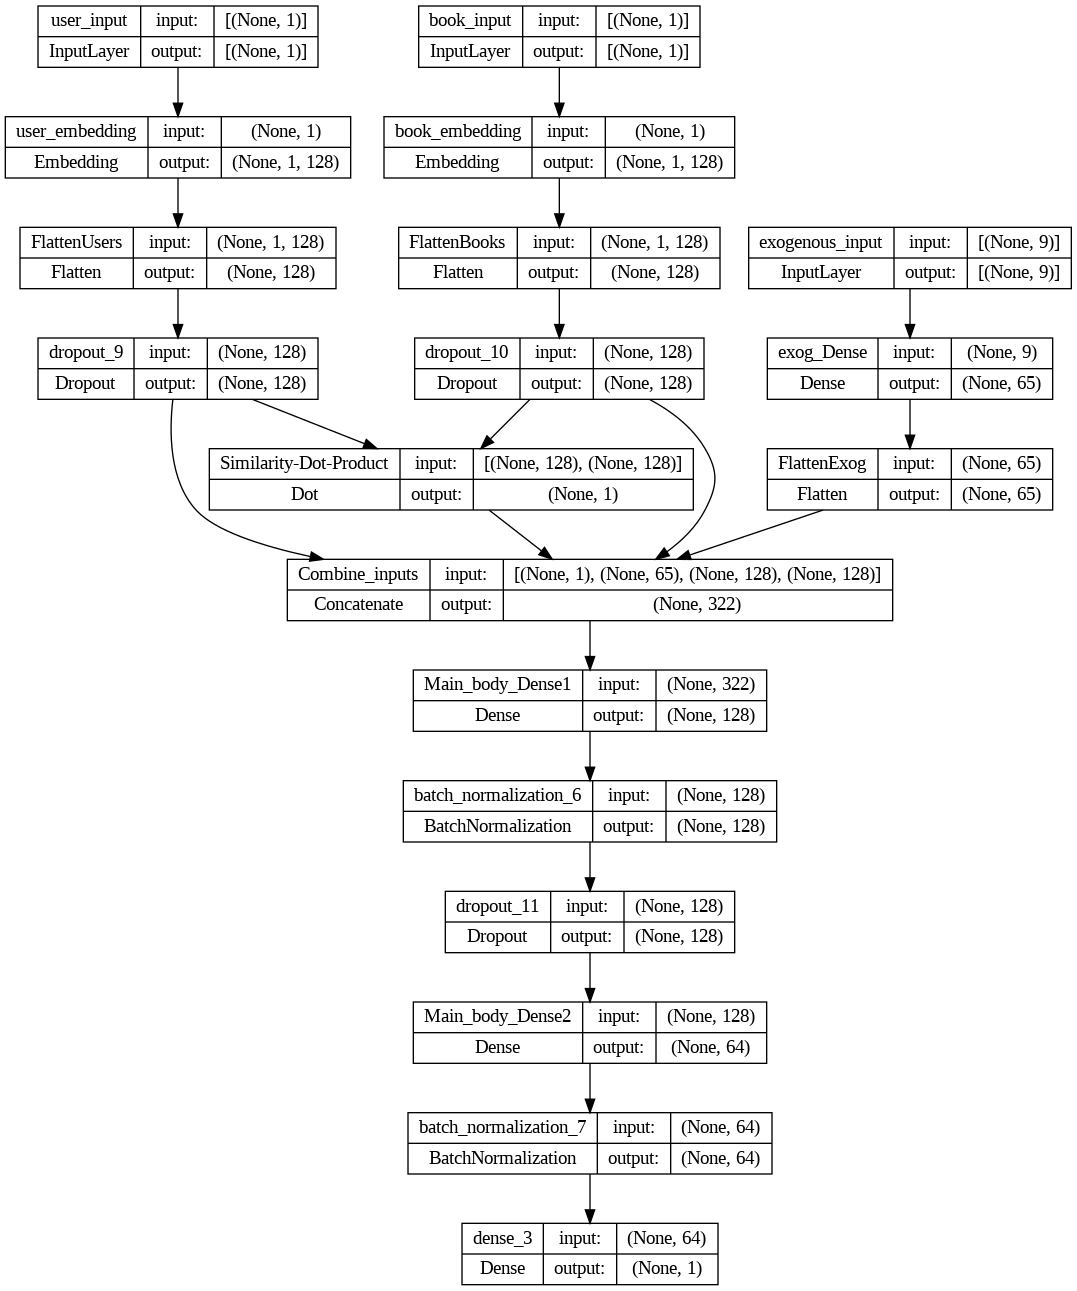

In [84]:
from keras.utils.vis_utils import plot_model
plot_model(nn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [85]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Dropout, dot, Add, BatchNormalization, concatenate, Activation
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def attention_layer(input_embedding, attention_size=32):
    """
    Implements an attention mechanism.
    """
    attention = Dense(attention_size, activation='tanh')(input_embedding)
    attention = Dense(1, activation='softmax')(attention)
    multiplied = tf.multiply(input_embedding, attention)
    return multiplied

def build_improved_model(dropout, latent_factors, reg_lambda=0.001):
    n_books = len(user_rating['Book_Id'].unique())
    n_users = len(user_rating['ID'].unique())
    n_latent_factors = latent_factors

    user_input = Input(shape=(1,), name='user_input', dtype='int64')
    user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
    user_vec = Flatten(name='FlattenUsers')(user_embedding)
    user_vec = Dropout(dropout)(user_vec)

    book_input = Input(shape=(1,), name='book_input', dtype='int64')
    book_embedding = Embedding(n_books, n_latent_factors, name='book_embedding')(book_input)
    book_vec_with_attention = attention_layer(book_embedding)
    book_vec = Flatten(name='FlattenBooks')(book_vec_with_attention)
    book_vec = Dropout(dropout)(book_vec)

    sim = dot([user_vec, book_vec], name='Similarity-Dot-Product', axes=1)

    exog_input = Input(shape=(9,), name='exogenous_input', dtype='float64')
    exog_embedding = Dense(65, activation='relu', kernel_regularizer=l2(reg_lambda), name='exog_Dense')(exog_input)
    exog_vec = Flatten(name='FlattenExog')(exog_embedding)

    nn_inp = concatenate([sim, exog_vec, book_vec, user_vec], name='Combine_inputs')
    nn_inp = Dense(128, activation='relu', kernel_regularizer=l2(reg_lambda), name='Main_body_Dense1')(nn_inp)
    nn_inp = BatchNormalization()(nn_inp)
    nn_inp = Dropout(dropout)(nn_inp)
    nn_inp = Dense(64, activation='relu', kernel_regularizer=l2(reg_lambda), name='Main_body_Dense2')(nn_inp)
    nn_inp = BatchNormalization()(nn_inp)
    nn_output = Dense(1, activation='relu')(nn_inp)

    nn_model = Model([user_input, book_input, exog_input], nn_output)
    return nn_model

# Build the improved model
improved_model = build_improved_model(0.3, 128)
improved_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 book_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 book_embedding (Embedding)     (None, 1, 128)       13114240    ['book_input[0][0]']             
                                                                                                  
 dense_4 (Dense)                (None, 1, 32)        4128        ['book_embedding[0][0]']         
                                                                                                  
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                            

In [86]:
nn_model.compile(optimizer=Adam(learning_rate=1e-4),loss='mse', metrics = ['mae'])
batch_size= 128
epochs= 20

History = nn_model.fit([np.array(X_train.ID),np.array(X_train.Book_Id),exogenous_train],y_train, batch_size=batch_size,
                              epochs =epochs, validation_data = ([np.array(X_test.ID),np.array(X_test.Book_Id),exogenous_valid],y_test),
                              verbose = 1)

Epoch 1/20
7162/7162 [==============================] - 71s 9ms/step - loss: 2.3996 - mae: 1.1310 - val_loss: 0.9519 - val_mae: 0.7744
Epoch 2/20
7162/7162 [==============================] - 61s 9ms/step - loss: 0.8297 - mae: 0.7228 - val_loss: 0.7456 - val_mae: 0.6905
Epoch 3/20
7162/7162 [==============================] - 62s 9ms/step - loss: 0.7345 - mae: 0.6761 - val_loss: 0.6929 - val_mae: 0.6617
Epoch 4/20
7162/7162 [==============================] - 61s 9ms/step - loss: 0.6757 - mae: 0.6443 - val_loss: 0.6412 - val_mae: 0.6322
Epoch 5/20
7162/7162 [==============================] - 60s 8ms/step - loss: 0.6241 - mae: 0.6154 - val_loss: 0.6026 - val_mae: 0.6108
Epoch 6/20
7162/7162 [==============================] - 60s 8ms/step - loss: 0.5723 - mae: 0.5860 - val_loss: 0.5425 - val_mae: 0.5716
Epoch 7/20
7162/7162 [==============================] - 60s 8ms/step - loss: 0.5095 - mae: 0.5497 - val_loss: 0.4758 - val_mae: 0.5264
Epoch 8/20
7162/7162 [==============================] -

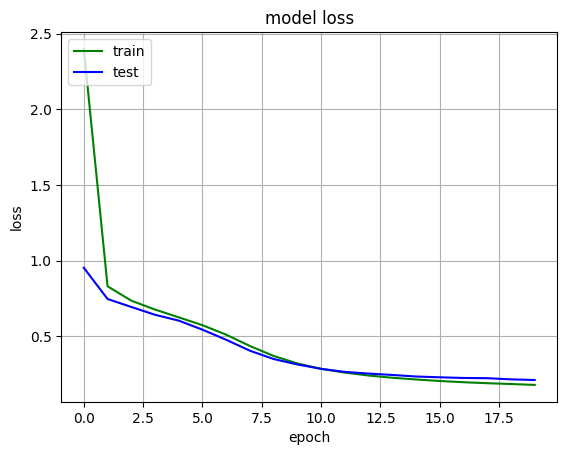

In [95]:
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [88]:
preds = nn_model.predict([X_test.ID,X_test.Book_Id,exogenous_valid])
avp = (preds,y_test)
df_id = pd.DataFrame(np.array(X_test.ID))
df_Book_id = pd.DataFrame(np.array(X_test.Book_Id))
df_actual_rating = pd.DataFrame(np.array(y_test))
df_preds = pd.DataFrame(preds)
dfList = [df_id, df_Book_id,df_actual_rating,df_preds]  # List of your dataframes
avp = pd.concat(dfList,ignore_index=True,axis=1)
#new_df = pd.concat([new_df,df_preds],ignore_index=True,axis=1)
avp.rename(columns={ avp.columns[0]: "ID" }, inplace = True)
avp.rename(columns={ avp.columns[1]: "Book_Id" }, inplace = True)
avp.rename(columns={ avp.columns[2]: "Rating_numeric" }, inplace = True)
avp.rename(columns={ avp.columns[3]: "Pred_Rating" }, inplace = True)
avp

7162/7162 [==============================] - 12s 2ms/step


,ID,Book_Id,Rating_numeric,Pred_Rating
0,2125,1125,4,3.970242
1,1138,1408,5,4.982919
2,2278,14708,5,5.016759
3,422,39103,3,3.013288
4,691,8354,2,2.080889
...,...,...,...,...
229174,1286,268,5,4.496901
229175,617,575,4,3.839012
229176,1150,70405,3,3.330276
229177,2209,96,5,5.005793


In [89]:
X_test.ID.unique()

array([2125, 1138, 2278, ..., 2093, 1108, 2107])

In [90]:
avp['Pred_Rating'].max(),avp['Pred_Rating'].min()

(5.1385927, 0.50996625)

In [91]:
def check_overlap(UserId,top_recos_to_check):
    samp_cust = avp[avp['ID']==UserId][['ID','Rating_numeric','Book_Id']]
    samp_cust.sort_values(by='Rating_numeric', ascending=False, inplace=True)
    available_actual_ratings = samp_cust.shape[0]
    rows_to_fetch = min(available_actual_ratings,top_recos_to_check)
    preds_df_sampcust = avp[avp['ID']==UserId][['ID','Pred_Rating','Book_Id']]
    preds_df_sampcust.sort_values(by='Pred_Rating', ascending=False, inplace=True)
    actual_rating = samp_cust.iloc[0:rows_to_fetch,:]
    pred_rating = preds_df_sampcust.iloc[0:rows_to_fetch,:]
    overlap = pd.Series(list(set(actual_rating.Book_Id).intersection(set(pred_rating.Book_Id))))
    pct_overlap = (len(overlap)/rows_to_fetch)*100
    #print("Percentage of overlap in top"+str(top_recos_to_check)+" for User ID - "+str(UserId)+" : "+str(pct_overlap))
    return pct_overlap

In [92]:
test_user_list = avp.ID.unique().tolist()
overlap_summary={}
top_recos_to_check =11
for users in test_user_list:
    overlap_summary[users]= check_overlap(users,top_recos_to_check)

<ipython-input-91-c6e48fa0d7d2>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  overlap = pd.Series(list(set(actual_rating.Book_Id).intersection(set(pred_rating.Book_Id))))
<ipython-input-91-c6e48fa0d7d2>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  overlap = pd.Series(list(set(actual_rating.Book_Id).intersection(set(pred_rating.Book_Id))))
<ipython-input-91-c6e48fa0d7d2>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  overlap = pd.Series(list(set(actual_rating.Book_Id).intersection(set(pred_rating.Book_Id))))
<ipython-input-91-c6e48fa0d7d2>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' 

In [93]:
sorted_summary = sorted(overlap_summary.items(), key=lambda x: x[1], reverse=True)
max_overlap = np.array(list(overlap_summary.values())).max()
min_overlap = np.array(list(overlap_summary.values())).min()
mean_overlap = np.array(list(overlap_summary.values())).mean()
print("Max overlap in top" +str(top_recos_to_check)+ " books "+str(max_overlap))
print("Min overlap in top "+str(top_recos_to_check)+ " books "+str(min_overlap))
print("Average overlap in top "+str(top_recos_to_check)+ " books "+str(mean_overlap))

Max overlap in top11 books 100.0
Min overlap in top 11 books 0.0
Average overlap in top 11 books 42.81451478187931


In [107]:
nn_model.save("/content/drive/MyDrive/Datasets/Goodreads/NCF_model.keras")

In [ ]:
def complete_preprocessing(book_rating, user_rating):
    """
    Complete preprocessing for the book_rating and user_rating DataFrames.

    Args:
    - book_rating (pd.DataFrame): Raw book rating data.
    - user_rating (pd.DataFrame): Raw user rating data.

    Returns:
    - user_rating_processed (pd.DataFrame): Preprocessed user rating data ready for the model.
    - book_rating_processed (pd.DataFrame): Preprocessed book rating data.
    """

    # Preprocessing for book_rating DataFrame
    book_rating['Num_1star_rating'] = book_rating['RatingDist1'].str.split(':').str[-1].astype(int)
    book_rating['Num_2star_rating'] = book_rating['RatingDist2'].str.split(':').str[-1].astype(int)
    book_rating['Num_3star_rating'] = book_rating['RatingDist3'].str.split(':').str[-1].astype(int)
    book_rating['Num_4star_rating'] = book_rating['RatingDist4'].str.split(':').str[-1].astype(int)
    book_rating['Num_5star_rating'] = book_rating['RatingDist5'].str.split(':').str[-1].astype(int)

    book_rating['Total_rating_count'] = book_rating[['Num_1star_rating', 'Num_2star_rating', 'Num_3star_rating', 'Num_4star_rating', 'Num_5star_rating']].sum(axis=1)

    # Create Book_Id for each book
    book_id_0 = book_rating[['Name']]
    book_id_1 = user_rating[['Name']]
    book_id = pd.concat([book_id_0, book_id_1], axis=0, ignore_index=True).drop_duplicates()
    book_id['Book_Id'] = book_id.index.values

    # Preprocessing for user_rating DataFrame
    user_rating = user_rating[user_rating['ID'].groupby(user_rating['ID']).transform('size') >= 15]
    user_rating = pd.merge(user_rating, book_id, on='Name', how='left')

    le = preprocessing.LabelEncoder()
    user_rating['Rating_numeric'] = le.fit_transform(user_rating.Rating.values)

    book_rating_numeric = book_rating[['Book_Id', 'pagesNumber', 'PublishMonth', 'PublishDay', 'CountsOfReview',
                                       'Num_1star_rating', 'Num_2star_rating', 'Num_3star_rating',
                                       'Num_4star_rating', 'Num_5star_rating']]
    user_rating = pd.merge(user_rating, book_rating_numeric, on='Book_Id', how='left').fillna(0)

    users = user_rating.ID.unique()
    books = user_rating.Book_Id.unique()
    userid2idx = {o: i for i, o in enumerate(users)}
    bookid2idx = {o: i for i, o in enumerate(books)}

    user_rating['ID'] = user_rating['ID'].apply(lambda x: userid2idx[x])
    user_rating['Book_Id'] = user_rating['Book_Id'].apply(lambda x: bookid2idx[x])

    return user_rating, book_rating

# Test the function using the provided datasets (assuming they are loaded)
# user_rating_processed, book_rating_processed = complete_preprocessing(book_rating, user_rating)
# user_rating_processed.head()


## Integration with content based:


In [129]:
new_df = pd.read_csv("/content/drive/MyDrive/Datasets/Goodreads/features.csv")

In [130]:
new_df["Id"] = new_df.Name.apply(lambda x: book2bookid[x])
new_df.head()

,Id,Name,keywords
0,1789109,vader's fortress (star wars: junior jedi knigh...,"star_wars:_junior_jedi_knights,_#5 rebecca_moe..."
1,884550,come look with me: latin american art (come lo...,kimberly_lane charlesbridge eng painting arti...
2,642059,the night before christmas in texas,catherine___smith gibbs_smith eng santa reind...
3,84040,zap! i'm a mind reader,dan_greenburg grosset_&_dunlap eng reading mi...
4,1059513,"longarm and the denver executioners (longarm, ...","longarm,_#275 tabor_evans jove eng marner cust..."


In [131]:
sampled_data = new_df.sample(n = 40000, random_state = 2).reset_index(drop = True)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8',
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(sampled_data["keywords"])

In [132]:
from sklearn.metrics.pairwise import cosine_similarity
book_cosine_sim = cosine_similarity(tfidf_encoding, tfidf_encoding)

In [153]:
sampled_data

,Id,Name,keywords
0,58012,looking good in print,roger_c._parker paraglyph_press eng publisher...
1,246872,"urgent care (the healing touch, #3)","the_healing_touch,_#3 hannah_alexander bethany..."
2,306416,athena,blake_hoena capstone_press eng mythology athe...
3,455400,sassafras (serendipity book),stephen_cosgrove price_stern_sloan eng elepha...
4,1176266,the age of mozart and beethoven,giorgio_pestelli cambridge_university_press e...
...,...,...,...
39995,676214,eggs in the coffee sheep in the corn: my 17 ye...,marjorie_myers_douglas minnesota_historical_s...
39996,1654820,"the summer garden (the bronze horseman, #3)","the_bronze_horseman,_#3 paullina_simons harper..."
39997,256224,"perfect girls (replica, #4)","replica,_#4 marilyn_kaye bantam,australia eng ..."
39998,1654663,it rhymes with lust,arnold_drake dark_horse_books eng comic write...


In [162]:
books = pd.Series(sampled_data['Id'])

def recommend_books_similar_to(book_id, n=5, cosine_sim_mat=book_cosine_sim, hashmap = bookid2book):
    # get index of the imput book
    input_idx = books[books == book_id].index[0]
    # Find top n similar books with decreasing order of similarity score
    top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending = False).iloc[1:n+1].index)
    # [1:6] to exclude 0 (index 0 is the input movie itself)

    books_list = list(books)
    recommended_books = [hashmap[books[i]] for i in top_n_books_idx]

    return recommended_books

In [164]:
recommend_books_similar_to(1049387)

['Dark Side of the Moon (Dark-Hunter, #9; Were-Hunter, #3)',
 'Fear the Darkness (Dark-Hunterverse #11.5)',
 'Dark Side of the Moon (Dark-Hunter, #10; Were-Hunter, #5)',
 'Kiss of the Night (Dark-Hunter, #4)',
 'Dead After Dark']

In [141]:
user_rating.ID

0             0
1             0
2             0
3             0
4             0
           ... 
1145887    2356
1145888    2356
1145889    2356
1145890    2356
1145891    2356
Name: ID, Length: 1145892, dtype: int64

In [147]:
content_model_ids = set(sampled_data.Id)

In [148]:
len(content_model_ids)

40000

In [167]:
user_rating[user_rating['Book_Id'] == 273323].sort_values(by='Rating_numeric', ascending=False).head()['ID']

Series([], Name: ID, dtype: int64)

As we have only a small sample of data in colaborative model, we tend to get empty list more-often

In [149]:
def content_based_recommendation(user_id, user_rating, content_model, top_n=10):
    # Get the top books the user has rated
    top_books = user_rating[user_rating['ID'] == user_id].sort_values(by='Rating_numeric', ascending=False).head(top_n)['Book_Id']

    # Fetch recommendations for each of these books and aggregate
    all_recommendations = []
    for book in top_books:
        # If the book exists in content_model, get recommendations
        if book in content_model:
            similar_books = recommend_books_similar_to(book)
            all_recommendations.extend(similar_books)

    # Return unique recommendations
    return list(set(all_recommendations))


In [151]:
content_based_recommendation(787, user_rating, content_model_ids)

[]